# Cross correlation with WISE Catalog 

In [1]:
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
from cmass_modules import *
%matplotlib inline

%load_ext autoreload
%autoreload 2

/n/home00/lee.5922/.local/lib/python2.7/site-packages/subprocess32.py:472: RuntimeWarning: The _posixsubprocess module is not being used. Child process reliability may suffer if your program uses threads.
  "program uses threads.", RuntimeWarning)


## Masking WISE Extended source catalog

In [2]:
def moon_cont_mask(cat):
    
    mask = np.zeros(cat.size, dtype = 'bool') #(cat['MOON_LEV']=='0000')
    #combinations = []
    for i in [0,1,2]:
        for j in [0,1,2]:
            for k in [0,1,2]:
                for l in [0,1,2]:
                    filt = '{}{}{}{}'.format(i,j,k,l)
                    mask +=(cat['MOON_LEV']==filt)
    return mask
 

In [3]:
def making_healpix_density_map(cat = None, nside = 128, nest = False):
    hpind = np.arange(hp.nside2npix(nside))
    cat_ind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside= nside, nest= nest)
    N_gal, _ = np.histogram(cat_ind, bins = np.append(hpind, hpind.size) )
    unseen = (N_gal != 0.0)
    pixarea = hp.nside2pixarea(nside = nside)
    ra,dec = hpHEALPixelToRaDec(hpind)
    Map = np.zeros( (hpind.size, ), dtype = [('RA', 'float'),('DEC', 'float'),('PIXEL', 'float'), ('N_GAL', 'float') \
                                            , ('WEIGHT', 'float') , ('WEIGHT_RAND', 'bool') ])
    Map['RA'] = ra
    Map['DEC'] = dec
    Map['PIXEL'] = hpind
    Map['N_GAL'] = N_gal*1./pixarea    
    Map['WEIGHT'] = N_gal*1./pixarea 
    Map['WEIGHT_RAND'] = unseen
    return Map

In [1]:
#from astropy.table import Table
#t = Table.read('/n/des/lee.5922/data/wise_cat/wise_allsky.allsky_4band_p3as_psd25158.tbl', format='ipac')
#t.write('/n/des/lee.5922/data/wise_cat/wise_allsky.allsky_4band_p3as_psd25158.fits', format='fits', overwrite=True)

In [ ]:
wise = esutil.io.read('/n/des/lee.5922/data/wise_cat/wise_allsky.allsky_4band_p3as_psd25158.fits',  upper=True)
HealInds = hpRaDecToHEALPixel(wise['RA'], wise['DEC'], nside=  512, nest= False)

wise = rf.append_fields(wise,'HEALIndex',HealInds,dtypes=HealInds.dtype)
cont_mask = moon_cont_mask(wise)
wise = wise[cont_mask]
#wise = wise[(wise['CC_FLAGS'] != '0000')]

In [21]:
reddening_nest = esutil.io.read('/n/des/lee.5922/data/2mass_cat/lambda_sfd_ebv.fits')
reddening_ring = hp.reorder(reddening_nest['TEMPERATURE'], inp='NEST', out='RING')
reddening = rotate_hp_map(reddening_ring, coord = ['C', 'G'])

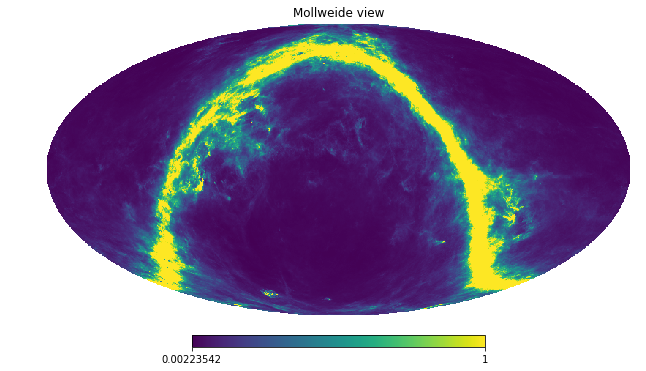

In [22]:
hp.mollview( reddening, max = 1, nest = False)

### Color correction 

In [23]:
mind = np.arange(hp.nside2npix(512))
reliable_hp_mask = (reddening < 0.05/0.367)
reliable_hpind = mind[reliable_hp_mask]
reliable_wise_mask = np.in1d(wise['HEALIndex'], reliable_hpind)
reliable_wise = wise[reliable_wise_mask]

In [95]:
reliable_wise['CC_FLAGS'][reliable_wise['CC_FLAGS']!='0000']

masked_array(data = ['d000' '00PP' 'hh00' ..., 'd000' 'hh00' 'dd00'],
             mask = [False False False ..., False False False],
       fill_value = N/A)

### Making Galaxy densty Map 

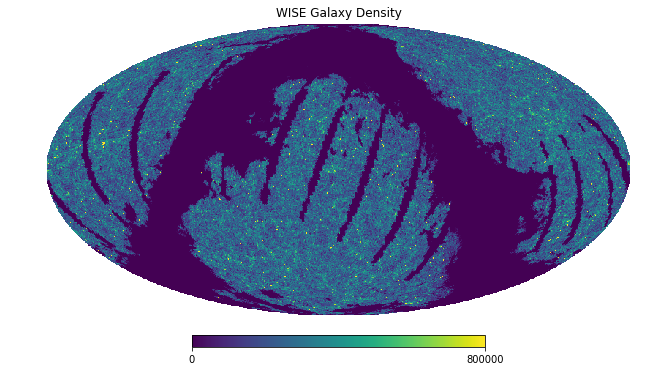

In [24]:
wise_galmap = making_healpix_density_map(cat = reliable_wise, nest = False, nside = 128)
hp.mollview(wise_galmap['WEIGHT'],  nest=False, title="WISE Galaxy Density", max = 8e+05)

### Cross correlation with CMASS SGC

In [46]:
#Making mask
#mind = np.arange(hp.nside2npix(512))
#reliable_hp_mask = (reddening['TEMPERATURE'] < 0.05)
#reliable_hpind = mind[reliable_hp_mask]
wise_galmap = making_healpix_density_map(cat = reliable_wise, nest = False, nside = 512)
reliable_hpind = wise_galmap['PIXEL'][ wise_galmap['WEIGHT_RAND'] ==1 ]
boss_hpind = esutil.io.read('/n/des/lee.5922/data/cmass_cat/healpix_boss_footprint_SGC_1024.fits')

In [47]:
#CMASS SGC
path = '/n/des/lee.5922/data/cmass_cat/'
cmass = esutil.io.read(path+'galaxy_DR12v5_CMASS_South.fits.gz')
#cmass = esutil.io.read(path+'galaxy_DR12v5_CMASS_North.fits.gz')
random = esutil.io.read(path+'random0_DR12v5_CMASS_South.fits.gz')
#random = esutil.io.read(path+'random0_DR12v5_CMASS_North.fits.gz')

In [27]:
dmass_spt = esutil.io.read('result_cat/dmass_spt.fits')
dmass_random = Cuts.keepGoodRegion(uniform_random_on_sphere(dmass_spt, size = dmass_spt.size * 30 ))

In [28]:
#2MASS RANDOMS
wise_random = uniform_random_on_sphere(wise, size = wise.size * 10 )
HPind_rand = hpRaDecToHEALPixel(wise_random['RA'], wise_random['DEC'], nside=  512, nest= False)
reliable_rand_mask = np.in1d(HPind_rand, reliable_hpind)
reliable_wise_random =  wise_random[reliable_rand_mask]

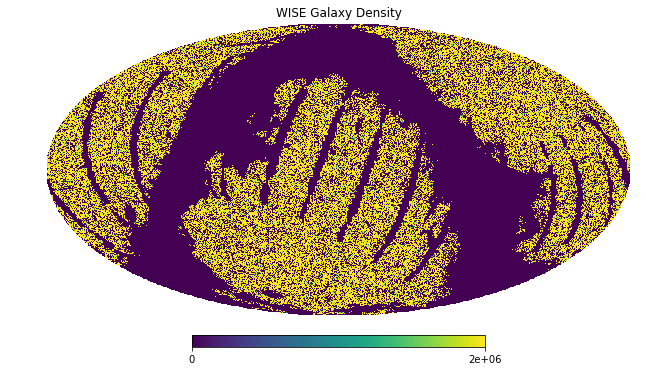

In [29]:
wise_random_galmap = making_healpix_density_map(cat = reliable_wise_random, nest = False, nside = 512)
hp.mollview(wise_random_galmap['WEIGHT'], nest=False, title="WISE Galaxy Density", max = 2e+06)

In [48]:
cmass_hp512 = hpRaDecToHEALPixel(cmass['RA'], cmass['DEC'], nside=  512, nest= False)
cmass_random_hp512 = hpRaDecToHEALPixel(random['RA'], random['DEC'], nside=  512, nest= False)
dmass_hp512 = hpRaDecToHEALPixel(dmass_spt['RA'], dmass_spt['DEC'], nside=  512, nest= False)
dmass_random_hp512 = hpRaDecToHEALPixel(dmass_random['RA'], dmass_random['DEC'], nside=  512, nest= False)

#twomass_hp4096 = hpRaDecToHEALPixel(reliable_twomass['RA'], reliable_twomass['DEC'], nside=  4096, nest= False)
#twomass_random_hp4096 = hpRaDecToHEALPixel(reliable_twomass_random['RA'], reliable_twomass_random['DEC'], nside=  4096, nest= False)
wise_hp1024 = hpRaDecToHEALPixel(reliable_wise['RA'], reliable_wise['DEC'], nside=  1024, nest= False)
wise_random_hp1024 = hpRaDecToHEALPixel(reliable_wise_random['RA'], reliable_wise_random['DEC'], nside=  1024, nest= False) 


In [49]:
cmass_in_wise_mask = np.in1d( cmass_hp512, reliable_hpind )
cmass_randoms_in_wise_mask = np.in1d( cmass_random_hp512, reliable_hpind )
dmass_in_wise_mask = np.in1d( dmass_hp512, reliable_hpind )
dmass_radoms_in_wise_mask = np.in1d( dmass_random_hp512, reliable_hpind )

#twomass_in_spt_mask = np.in1d( twomass_hp4096, goldmask_hpind )
#twomass_random_in_spt_mask = np.in1d( twomass_random_hp4096, goldmask_hpind )
wise_in_cmass_mask = np.in1d( wise_hp1024, boss_hpind )
wise_random_in_cmass_mask = np.in1d( wise_random_hp1024, boss_hpind )

In [50]:
cmass_in_wise = cmass[cmass_in_wise_mask]
cmass_randoms_in_wise = random[cmass_randoms_in_wise_mask]
dmass_in_wise = dmass_spt[dmass_in_wise_mask]
dmass_randoms_in_wise = dmass_random[dmass_radoms_in_wise_mask]

wise_in_spt = Cuts.keepGoodRegion(reliable_wise[reliable_wise['DEC']<-3.0])
wise_random_in_spt = Cuts.keepGoodRegion(reliable_wise_random[reliable_wise_random['DEC']<-3.0])

wise_in_cmass = reliable_wise[wise_in_cmass_mask]
wise_random_in_cmass = reliable_wise_random[wise_random_in_cmass_mask]

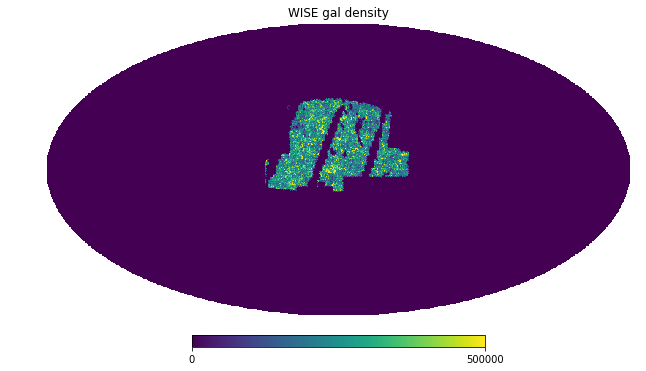

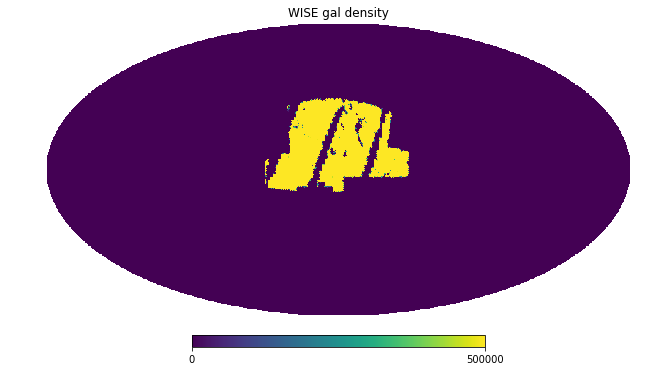

In [51]:
wise_in_cmass_galmap= making_healpix_density_map(cat = wise_in_cmass, nside = 128, nest = False)
hp.mollview(wise_in_cmass_galmap['WEIGHT'], nest=False, title="WISE gal density", max = 5e05)

wise_random_in_cmass_galmap= making_healpix_density_map(cat = wise_random_in_cmass, nside = 128, nest = False)
hp.mollview(wise_random_in_cmass_galmap['WEIGHT'], nest=False, title="WISE gal density", max = 5e05)

In [52]:
w_sgc = cmass_in_wise['WEIGHT_FKP'] * cmass_in_wise['WEIGHT_SYSTOT']*( cmass_in_wise['WEIGHT_CP'] + cmass_in_wise['WEIGHT_NOZ'] - 1. )
w_rand = cmass_randoms_in_wise['WEIGHT_FKP']
cmass_in_wise = rf.append_fields(cmass_in_wise,'WEIGHT', w_sgc, dtypes=w_sgc.dtype)
cmass_randoms_in_wise = rf.append_fields(cmass_randoms_in_wise,'WEIGHT_RAND', w_rand, dtypes=w_rand.dtype)

w_wise = np.ones(wise_in_cmass.size)
w_wise_rand = np.ones(wise_random_in_cmass.size)
wise_in_cmass = rf.append_fields(wise_in_cmass,'WEIGHT', w_wise)
wise_random_in_cmass = rf.append_fields(wise_random_in_cmass,'WEIGHT_RAND', w_wise_rand)

w_dmass = np.ones(dmass_in_wise.size)
w_dmass_rand = np.ones(dmass_randoms_in_wise.size)
dmass_in_wise = rf.append_fields(dmass_in_wise,'WEIGHT', w_dmass)
dmass_randoms_in_wise = rf.append_fields(dmass_randoms_in_wise,'WEIGHT_RAND', w_dmass_rand)

w_dmass = np.ones(wise_in_spt.size)
w_dmass_rand = np.ones(wise_random_in_spt.size)
wise_in_spt = rf.append_fields(wise_in_spt,'WEIGHT', w_dmass)
wise_random_in_spt = rf.append_fields(wise_random_in_spt,'WEIGHT_RAND', w_dmass_rand)


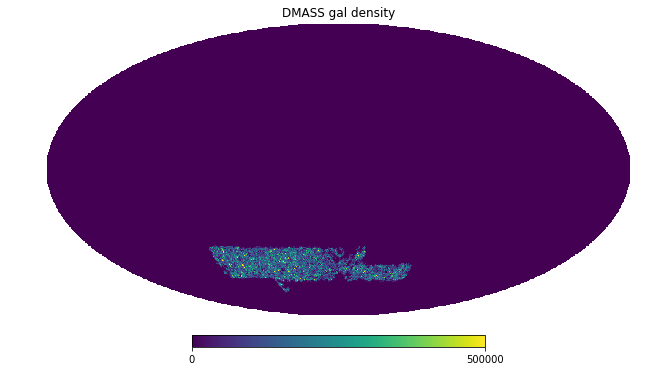

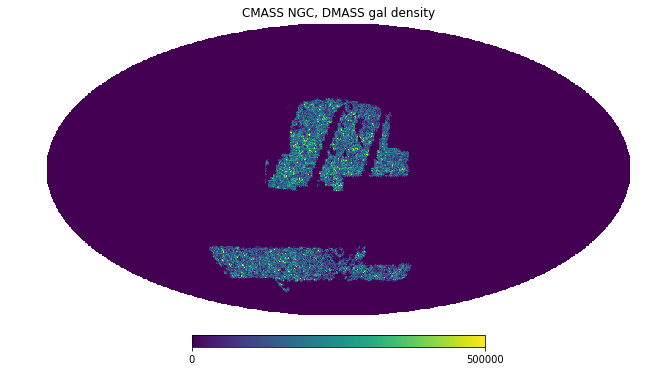

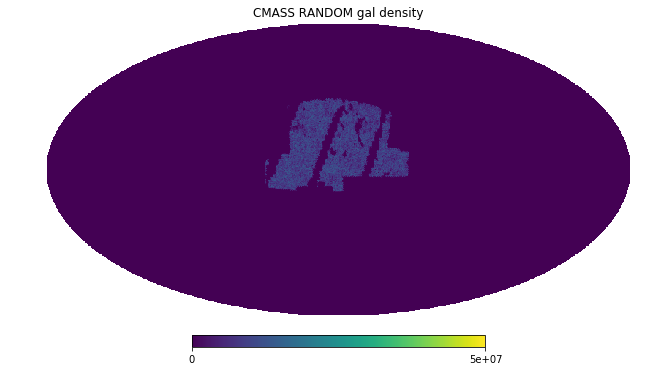

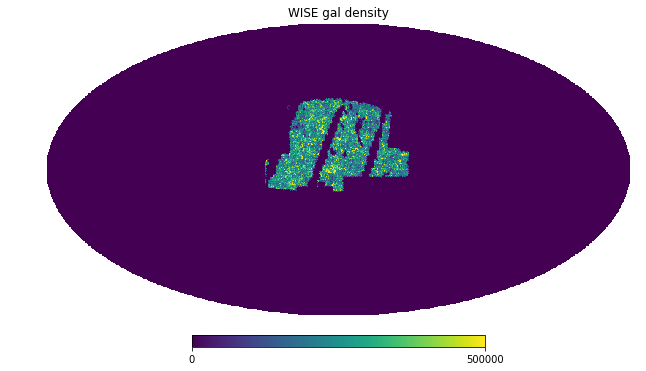

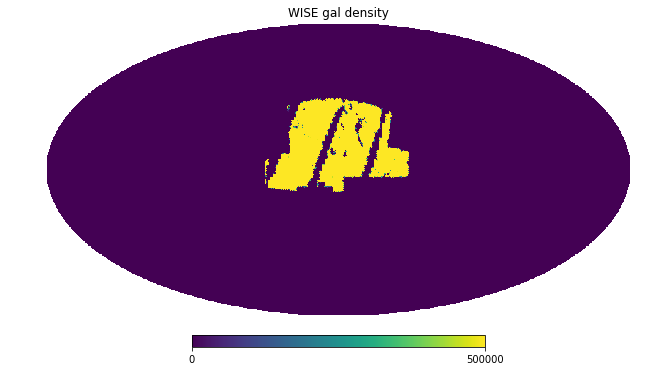

In [53]:
dmass_in_wise_galmap= making_healpix_density_map(cat = dmass_in_wise, nside = 128, nest = False)
hp.mollview(dmass_in_wise_galmap['WEIGHT'], nest=False, title="DMASS gal density", max = 5e05)

cmass_in_wise_galmap= making_healpix_density_map(cat = cmass_in_wise, nside = 128, nest = False)
hp.mollview(cmass_in_wise_galmap['WEIGHT'] + dmass_in_wise_galmap['WEIGHT'], nest=False, title="CMASS NGC, DMASS gal density", max = 5e05)

cmass_randoms_in_wise_galmap= making_healpix_density_map(cat = cmass_randoms_in_wise, nside = 128, nest = False)
hp.mollview(cmass_randoms_in_wise_galmap['WEIGHT'], nest=False, title="CMASS RANDOM gal density", max = 5e07)

wise_in_cmass_galmap= making_healpix_density_map(cat = wise_in_cmass, nside = 128, nest = False)
hp.mollview(wise_in_cmass_galmap['WEIGHT'], nest=False, title="WISE gal density", max = 5e05)

wise_random_in_cmass_galmap= making_healpix_density_map(cat = wise_random_in_cmass, nside = 128, nest = False)
hp.mollview(wise_random_in_cmass_galmap['WEIGHT'], nest=False, title="WISE gal density", max = 5e05)



In [54]:
print 'catalog size cmass', cmass_in_wise.size, cmass_randoms_in_wise.size
print 'catalog size dmass', dmass_in_wise.size, dmass_randoms_in_wise.size
print 'catalog size wise', wise_in_cmass.size, wise_random_in_cmass.size
print 'catalog size wise', wise_in_spt.size, wise_random_in_spt.size


catalog size cmass 122147 6080617
catalog size dmass 70039 417464
catalog size wise 183984 1175098
catalog size wise 103569 669201


#### Cross Correlation Function

In [40]:
from systematics_module.corr import angular_correlation, cross_angular_correlation

In [263]:
random_ind = np.random.choice(np.arange(cmass_randoms_in_wise.size), size = cmass_in_wise.size*10)
angular_correlation(data = cmass_in_wise, 
                    rand = cmass_randoms_in_wise[random_ind], 
                    weight = None, suffix = '_cmass_in_wise', njack=10)

#angular_correlation(data = wise_in_cmass, 
#                    rand = wise_random_in_cmass, 
#                    weight = None, suffix = '_wise_in_cmass', njack=10)

#angular_correlation(data = dmass_in_wise, 
#                    rand = dmass_random_in_wise, 
#                    weight = None, suffix = '_dmass_in_wise', njack=10)

calculate angular correlation function
X (1102, 2)  centers (10, 2)  tol=1e-05  maxiter=200
23 iterations  cluster sizes: [107 123 104 120 108 129  96  72 103 140]
X (303702, 2)  centers (10, 2)  tol=1e-05  maxiter=200
15 iterations  cluster sizes: [31307 34354 33029 30064 24287 30365 30254 20397 31564 38081]
saving data file to :  data_txt/acf_comparison_cmass_in_wise.txt


0

In [87]:
random_ind = np.random.choice(np.arange(cmass_randoms_in_wise.size), size = cmass_in_wise.size*5)
cross_angular_correlation(data = cmass_in_wise, 
                          data2 = wise_in_cmass, 
                          rand = cmass_randoms_in_wise[random_ind], 
                          rand2= wise_random_in_cmass, njack = 10,  
                          weight = [None, None, None, None], suffix = '_wise_x_cmass_sgc_no4')


cross_angular_correlation(data = dmass_in_wise, 
                          data2 = wise_in_spt, 
                          rand = dmass_randoms_in_wise, 
                          rand2= wise_random_in_spt, njack = 10,  
                          weight = [True, True, True, True], suffix = '_wise_x_dmass_no3')

X (698, 2)  centers (10, 2)  tol=1e-05  maxiter=200
11 iterations  cluster sizes: [ 78  87  68  66  78 101  67  61  54  38]
X (122147, 2)  centers (10, 2)  tol=1e-05  maxiter=200
19 iterations  cluster sizes: [14629 15199 13126 10299 11860 15360 11452 11070 10359  8793]
saving data file to :  data_txt/acf_cross_wise_x_cmass_sgc_no4.txt
X (529, 2)  centers (10, 2)  tol=1e-05  maxiter=200
21 iterations  cluster sizes: [70 42 43 45 58 75 49 44 45 58]
X (70039, 2)  centers (10, 2)  tol=1e-05  maxiter=200
17 iterations  cluster sizes: [7773 7962 7359 5763 6937 8907 6475 6630 6377 5856]
saving data file to :  data_txt/acf_cross_wise_x_dmass_no3.txt


In [76]:
m1, m2 = np.mgrid[0:20, 0:20]
m1.shape

(20, 20)

0.691868992401 1.03020500999


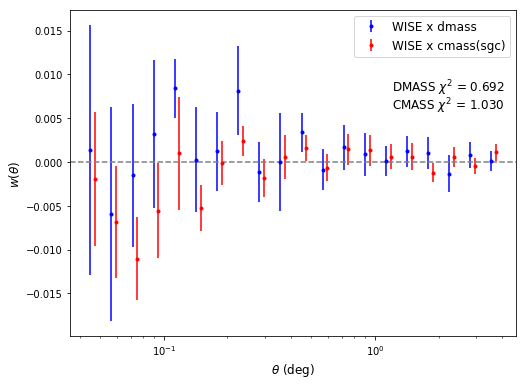

In [88]:
DAT = np.loadtxt('data_txt/acf_cross_wise_x_dmass_no3.txt')
meanr, xi, xi_err = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('data_txt/acf_cross_wise_x_cmass_sgc_no4.txt')
meanr3, xi3, xi_err3 = [DAT[:,i] for i in range(3)]
#DAT2 = np.loadtxt('data_txt/acf_cross_wise_x_cmass_sgc.txt')
#meanr4, xi4, xi_err4 = [DAT2[:,i] for i in range(3)]

fig, ax = plt.subplots(figsize = (8, 6))
ax.errorbar(meanr*0.95, xi, yerr = xi_err, fmt = '.b', label='WISE x dmass')
#ax.errorbar(meanr2, xi2, yerr = xi_err2, fmt = '.r', label='cmass auto')
#ax.errorbar(meanr*1.05, xi, yerr = xi_err, fmt = '.r', label='dmass spt low')
ax.errorbar(meanr3, xi3, yerr = xi_err3, fmt = '.r', label='WISE x cmass(sgc)')
#ax.errorbar(meanr4*1.05, xi4, yerr = xi_err4, fmt = '.k', label='WISE x cmass(sgc)')


#ax.errorbar(meanr3*0.95, xi3, yerr = xi_err3, fmt = '.b', label='dmass spt rand')
#chisqr = np.sum( (xi4-xi3)**2/xi_err3**2 )*1./xi3.size

chisqr = np.sum( (xi-0.0)**2/xi_err**2 )*1./xi.size
chisqr3 = np.sum( (xi3-0.0)**2/xi_err3**2 )*1./xi3.size
print chisqr, chisqr3

ax.text(1.2, 0.008, r'DMASS $\chi^2$ = {:0.3f}'.format(chisqr), fontsize = 12)
ax.text(1.2, 0.006, r'CMASS $\chi^2$ = {:0.3f}'.format(chisqr3), fontsize = 12)
ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(loc = 'best', fontsize = 12)
#ax.text(1.5, 0.07, r'$\chi^2$ = {:0.3f}'.format(chisqr), fontsize = 12)
#ax.set_ylim(1e-3,)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 12)
ax.set_ylabel(r'$w(\theta)$', fontsize = 12)
ax.axhline(y = 0.0, color = 'grey', linestyle = '--')

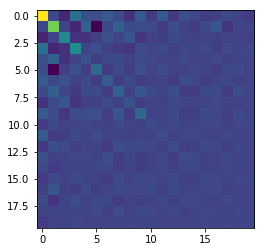

In [93]:
fig, ax = plt.subplots()
cov = np.genfromtxt('.cov_angular')
ax.imshow(cov)

In [92]:
np.dot(np.dot(xi3, np.linalg.inv(cov)), xi3)

-20566088471192648.0

In [100]:
np.linalg.inv(cov).diagonal()

array([  1.16836378e+18,   9.95970077e+18,  -5.69920572e+19,
         2.67170176e+19,  -5.44503846e+20,   1.02580968e+19,
         1.62463224e+20,   1.55330661e+20,  -7.77307009e+20,
        -7.73560072e+19,   6.24511517e+20,   1.45979568e+20,
        -5.17120618e+20,   5.48081249e+20,   7.72098679e+20,
         3.32740887e+20,   1.37129938e+21,  -4.44022554e+20,
        -8.35635533e+21,   2.31177789e+21])

figsave : figure/spatialtest_.png


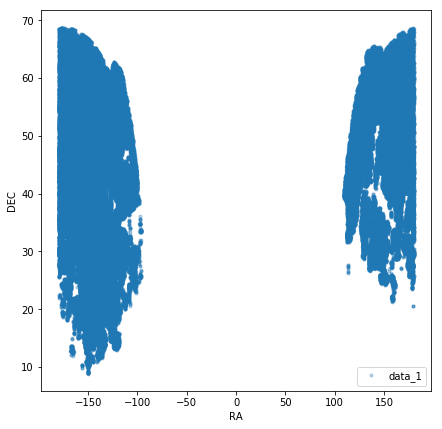

In [37]:
spatialcheck([cmass_in_wise])

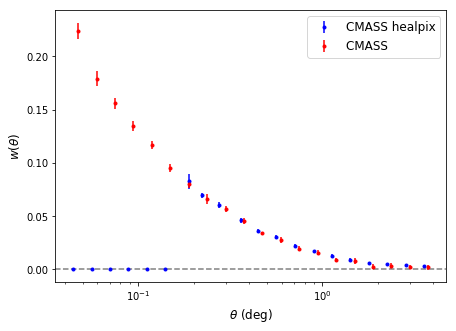

In [273]:
DAT = np.loadtxt('data_txt/acf_comparison_cmass_auto.txt')
meanr, xi, xi_err = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('data_txt/acf_comparison_cmass_in_wise.txt')
meanr2, xi2, xi_err2 = [DAT[:,i] for i in range(3)]


DAT = np.loadtxt('data_txt/acf_cross_wise_x_cmass.txt')
meanr3, xi3, xi_err3 = [DAT[:,i] for i in range(3)]
DAT2 = np.loadtxt('data_txt/acf_cross_wise_x_cmass_sgc.txt')
meanr4, xi4, xi_err4 = [DAT2[:,i] for i in range(3)]

fig, ax = plt.subplots(figsize = (7, 5))
ax.errorbar(meanr*0.95, xi, yerr = xi_err, fmt = '.b', label='CMASS healpix')
ax.errorbar(meanr2, xi2, yerr = xi_err2, fmt = '.r', label='CMASS ')
#ax.errorbar(meanr*1.05, xi, yerr = xi_err, fmt = '.r', label='dmass spt low')
#ax.errorbar(meanr3, xi3, yerr = xi_err3, fmt = '.r', label='WISE x cmass')
#ax.errorbar(meanr4*1.05, xi4, yerr = xi_err4, fmt = '.k', label='WISE x cmass(sgc)')


#ax.errorbar(meanr3*0.95, xi3, yerr = xi_err3, fmt = '.b', label='dmass spt rand')
#chisqr = np.sum( (xi4-xi3)**2/xi_err3**2 )*1./xi3.size

ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(loc = 'best', fontsize = 12)
#ax.text(1.5, 0.07, r'$\chi^2$ = {:0.3f}'.format(chisqr), fontsize = 12)
#ax.set_ylim(1e-3,)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 12)
ax.set_ylabel(r'$w(\theta)$', fontsize = 12)
ax.axhline(y = 0.0, color = 'grey', linestyle = '--')

saving fig to  figure/hist_z_test.png


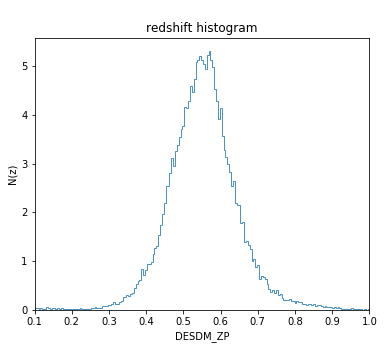

In [212]:
doVisualization_z_1(cats = [dmass_in_twomass])